In [ ]:
%pip install scanpy scvi-tools anndata
%pip install --quiet gdown
%pip install seaborn
%pip install --quiet bbknn
%pip install pandas
%pip install pyscenic
%pip install ipywidgets
%pip install MulticoreTSNE
%pip install scipy
%pip install scikit-misc

^C
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.


Import packages

In [1]:
import scanpy as sc
import anndata as ad
from anndata.experimental.multi_files import AnnCollection
import os
import tarfile
import scvi
import numpy as np
import glob
#specific requirements of pyscenic
import loompy as lp

## This is T-SNE, download has wheel error, could fix... could use UM
#from MulticoreTSNE import MulticoreTSNE as TSNE

#data vis
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import umap

d:\Coding\comp_bio\endometrial_analysis\.venv\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
d:\Coding\comp_bio\endometrial_analysis\.venv\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
d:\Coding\comp_bio\endometrial_analysis\.venv\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
d:\Coding\comp_bio\endometrial_analysis\.venv\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
d:\Coding\comp_bio\endometrial_analysis\.venv\Lib\site-packages\anndata\utils.py:429: Futu

In [ ]:
import shutil

total, used, free = shutil.disk_usage("/")
print(f"Total: {total // (2**30)} GiB")
print(f"Used: {used // (2**30)} GiB")
print(f"Free: {free // (2**30)} GiB")

In [ ]:

# Function to extract tar.gz files
def extract_tar_gz(tar_gz_path, extract_dir):
    with tarfile.open(tar_gz_path, "r:gz") as tar:
        tar.extractall(path=extract_dir)

# Directory containing your datasets
input_dir = "input/biostudiesarrayE-MTAB-14039"
extracted_dir = "input/extracted_data"  # Folder to save the extracted files
os.makedirs(extracted_dir, exist_ok=True)

# List all top-level files in the input directory
tar_gz_files = [f for f in os.listdir(input_dir) if f.endswith('.tar.gz')]

# Extract tar.gz files
for tar_gz_file in tar_gz_files:
    tar_gz_path = os.path.join(input_dir, tar_gz_file)
    
    # Extract the tar.gz file to the extracted directory
    extract_tar_gz(tar_gz_path, extracted_dir)


In [ ]:

# Directory where the files have been extracted
extracted_work_dir = "input/extracted_data"  # Directory where you extracted the tar files
# List to store directory names under the 'work' directory
dataset_dirs = []

# Traverse the 'work' directory to find subdirectories
for root, dirs, files in os.walk(extracted_work_dir):
    # Only consider directories directly under the 'work' directory
    if "work" in root:
        for dir_name in dirs:
            path = os.path.join(root, dir_name)
            # Append the directory name under 'work'
            dataset_dirs.append(path)

# Now dataset_dirs contains the names of all subdirectories under 'work'
print("Dataset directories under 'work':", dataset_dirs)


In [ ]:
print(dataset_dirs)


Docs: https://anndata.readthedocs.io/en/latest/tutorials/notebooks/anncollection.html
https://ccbskillssem.github.io/assets/scvi_notebook.html

warning: "If you use join='outer' this fills 0s for sparse data when variables are absent in a batch. Use this with care. Dense data is filled with NaN."

https://discourse.scverse.org/t/how-to-concatenate-anndata-properly/887/2
strongly recommends datacleaning each dataset before concatenating -- assuming that they did it for us

In [ ]:

hd5a_files_directory = r"input/hd5a_files"
if not os.path.exists(hd5a_files_directory):
    os.makedirs(hd5a_files_directory) 
adatas_dict = {}
for directory in dataset_dirs:
    adata = sc.read_10x_mtx(directory)
    adata.X = adata.X.tocsr()
    #dir_name = directory.split("\\")[-1]
    dir_name = os.path.basename(directory) #platform independent
    h5ad_filename = f"{dir_name}.h5ad"

    h5ad_path = os.path.join(hd5a_files_directory, h5ad_filename)
    adata.write(h5ad_path)
    adatas_dict[dir_name] = h5ad_path


In [ ]:
print(adatas_dict)

In [ ]:
output_directory = r"output/"
combined_on_disk_name = os.path.join(output_directory, 'data_combined_on_disk.h5ad') 
#os.remove(combined_on_disk_name)
ad.experimental.concat_on_disk(
    adatas_dict,          # List of paths to the individual .h5ad files
    combined_on_disk_name,  # Path to the combined output file
    label='dataset'      # Optional: label for the datasets
)

In [2]:
combined_adata = sc.read("output/data_combined_on_disk.h5ad")
combined_adata.obs_names_make_unique() 
##collection -- nice way to interact with the data separately:
#ann_collection = AnnCollection(adatas_dict, join_vars='outer', join_obs=None, label='dataset')
#collection_name = output_directory + 'data_collection.h5ad'
##not sure how to save the object for an easy reload

d:\Coding\comp_bio\endometrial_analysis\.venv\Lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
##METHOD USING BATCHING -- broken???
# # Directory where the files have been extracted
# extracted_work_dir = "input/extracted_data"  # Directory where you extracted the tar files
# # List to store directory names under the 'work' directory
# dataset_dirs = []

# # Traverse the 'work' directory to find subdirectories
# for root, dirs, files in os.walk(extracted_work_dir):
#     # Only consider directories directly under the 'work' directory
#     if "work" in root:
#         for dir_name in dirs:
#             path = os.path.join(root, dir_name)
#             # Append the directory name under 'work'
#             dataset_dirs.append(path)

# # Now dataset_dirs contains the names of all subdirectories under 'work'
# print("Dataset directories under 'work':", dataset_dirs)



# # List to store AnnData objects for merging
# adatas = []
# batch_size = 5  # Adjust based on available memory
# for i in range(0, len(dataset_dirs), batch_size):
#     # Get the current batch of files
#     batch_files = dataset_dirs[i:i+batch_size]
    
#     # Load the current batch of datasets
#     batch_adatas = []
#     for mtx_file in batch_files:
#         print(mtx_file)
#         # Assuming each batch is loaded from corresponding directories
#         adata = sc.read_10x_mtx(mtx_file)
#         batch_adatas.append(adata)
    
#     # Concatenate the current batch
#     if adatas:
#         adatas[0] = ad.concat([adatas[0]] + batch_adatas)
#         adatas[0].obs_names_make_unique() 
#     else:
#         adatas = batch_adatas

#     # Free memory by clearing the batch Adatas
#     batch_adatas = []

Load in data -- OLAF's VERSION. Garrett Depending on what you did you made need to make a different block.

Data Exploration

In [8]:
combined_adata = sc.read("output/data_combined_on_disk.h5ad")
combined_adata.obs_names_make_unique()

d:\Coding\comp_bio\endometrial_analysis\.venv\Lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [9]:
combined_adata.obs.head()


,dataset
AAACCCAAGGCTTTCA-1,FRZFRESH_GX25_ES345
AAACCCACAAGCTCTA-1,FRZFRESH_GX25_ES345
AAACCCAGTACGGTTT-1,FRZFRESH_GX25_ES345
AAACCCAGTAGGACCA-1,FRZFRESH_GX25_ES345
AAACCCATCCCGAGGT-1,FRZFRESH_GX25_ES345


In [10]:
#combined_adata = combined_adata[~combined_adata.obs['dataset'].str.contains('Endo', na=False)]
#combined_adata.obs['dataset']

In [11]:
from scipy import sparse

sparse_X = sparse.csr_matrix(combined_adata.X)
combined_adata.X = sparse_X

In [12]:


combined_adata.var.head()



""
MIR1302-2HG
FAM138A
OR4F5
AL627309.1
AL627309.3


In [13]:
print(combined_adata.var_names)
combined_adata.X

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.5', 'AL627309.4', 'AP006222.2', 'AL732372.1',
       ...
       'AC133551.1', 'AC136612.1', 'AC136616.1', 'AC136616.3', 'AC136616.2',
       'AC141272.1', 'AC023491.2', 'AC007325.1', 'AC007325.4', 'AC007325.2'],
      dtype='object', length=36601)


<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 1649327264 stored elements and shape (467190, 36601)>

In [14]:
combined_adata.obs
#output_file = "output/integrated_data.h5ad"
#combined_adata.write(output_file) # might just be failing because it already exists

,dataset
AAACCCAAGGCTTTCA-1,FRZFRESH_GX25_ES345
AAACCCACAAGCTCTA-1,FRZFRESH_GX25_ES345
AAACCCAGTACGGTTT-1,FRZFRESH_GX25_ES345
AAACCCAGTAGGACCA-1,FRZFRESH_GX25_ES345
AAACCCATCCCGAGGT-1,FRZFRESH_GX25_ES345
...,...
TTGCCTGCACTGAGTT-1,UA_Endo9426402_FX9006
TTGTGTTTCATTCTTG-1-1,UA_Endo9426402_FX9006
TTTACTGGTTAGAAAC-1,UA_Endo9426402_FX9006
TTTCATGCAAAGGCAC-1,UA_Endo9426402_FX9006


## Quality Control

In [15]:
combined_adata.var['MT'] = combined_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(combined_adata, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)


combined_adata.obs.head()



,dataset,n_genes_by_counts,total_counts,total_counts_MT,pct_counts_MT
AAACCCAAGGCTTTCA-1,FRZFRESH_GX25_ES345,3737,15451.0,1092.0,7.067504
AAACCCACAAGCTCTA-1,FRZFRESH_GX25_ES345,2225,4539.0,212.0,4.670632
AAACCCAGTACGGTTT-1,FRZFRESH_GX25_ES345,3379,11695.0,1544.0,13.202223
AAACCCAGTAGGACCA-1,FRZFRESH_GX25_ES345,2307,6950.0,700.0,10.071942
AAACCCATCCCGAGGT-1,FRZFRESH_GX25_ES345,2487,7820.0,658.0,8.414322


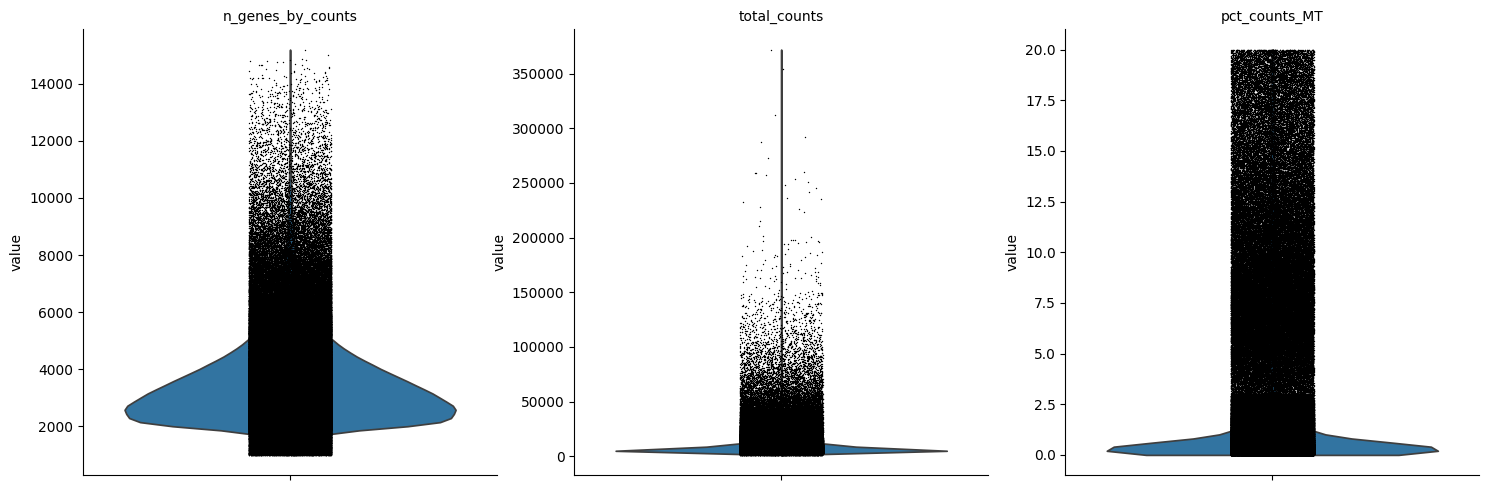

In [16]:
sc.pl.violin(
    combined_adata, 
    [
     'n_genes_by_counts', 
     'total_counts', 
     'pct_counts_MT'
     ],
    multi_panel=True
)

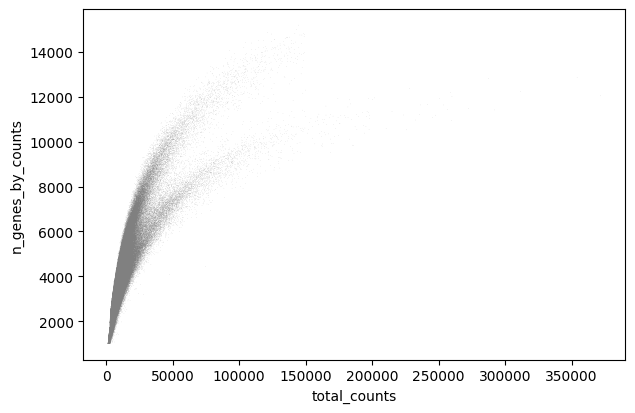

In [17]:
sc.pl.scatter(combined_adata, "total_counts", "n_genes_by_counts")

In [18]:
sc.pp.filter_cells(combined_adata, min_genes=100)
sc.pp.filter_genes(combined_adata, min_cells=3)

MemoryError: Unable to allocate 6.14 GiB for an array with shape (1649326510,) and data type float32

In [ ]:
sc.pp.scrublet(adata, batch_key="sample")

In [ ]:
#os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
#combined_adata = sc.read("output/integrated_data.h5ad")

### Normalization

In [ ]:
combined_adata.layers["counts"] = combined_adata.X.copy()
sc.pp.normalize_total(combined_adata, target_sum=1e4) 
sc.pp.log1p(combined_adata) 
combined_adata.raw = combined_adata

In [ ]:
sc.pp.highly_variable_genes(
    combined_adata,
    n_top_genes=4000,
    # subset=True, # to automatically subset to the 4000 genes
    layer="counts",
    flavor="seurat_v3"
)
sc.pl.highly_variable_genes(combined_adata, log=True)

In [ ]:
combined_adata = combined_adata[:, combined_adata.var.highly_variable].copy()
combined_adata.raw.to_adata()

### Standard Workflow

In [ ]:
sc.pp.scale(combined_adata) # z normalize the columns (genes)
sc.tl.pca(combined_adata)


combined_adata.obsm["X_pca"]
sc.pp.neighbors(combined_adata) # compute nearest neighbors
sc.tl.umap(combined_adata)
sc.pl.umap(combined_adata, color="batch")

IF THE CLUSTERS ARE BY BATCH:: ADD THIS CODE:

In [ ]:

import scanpy.external as sce
sce.pp.bbknn(adata, batch_key="batch")
sc.tl.umap(adata)
sc.pl.umap(adata, color=["batch", "cell_types"], ncols=1)


IF IT STILL DOESN'T WORK THEN REDO THE LOAD IN AND USE SCIVI
https://ccbskillssem.github.io/assets/scvi_notebook.html

https://www.youtube.com/watch?v=EKTg9NV5hEA

## SCENIC

##### STEP 1: IDENTIFY TF with arboreto 


In [ ]:
f_tfs = "/ddn1/vol1/staging/leuven/stg_00002/lcb/cflerin/resources/allTFs_hg38.txt"

!pyscenic grn {f_loom_path_scenic} {f_tfs} -o adj.csv --num_workers 20

adjacencies = pd.read_csv("adj.tsv", index_col=False, sep='\t')
adjacencies.head()

##### STEP 2: Refine regulons through pruning 

In [ ]:

# ranking databases
f_db_glob = "/ddn1/vol1/staging/leuven/res_00001/databases/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc9nr/gene_based/*feather"
f_db_names = ' '.join( glob.glob(f_db_glob) )

# motif databases
f_motif_path = "/ddn1/vol1/staging/leuven/res_00001/databases/cistarget/motif2tf/motifs-v9-nr.hgnc-m0.001-o0.0.tbl"

In [ ]:
!pyscenic ctx adj.tsv \
    {f_db_names} \
    --annotations_fname {f_motif_path} \
    --expression_mtx_fname {f_loom_path_scenic} \
    --output reg.csv \
    --mask_dropouts \
    --num_workers 20

In [ ]:
nGenesDetectedPerCell = np.sum(adata.X>0, axis=1)
percentiles = nGenesDetectedPerCell.quantile([.01, .05, .10, .50, 1])
print(percentiles)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=150)
sns.distplot(nGenesDetectedPerCell, norm_hist=False, kde=False, bins='fd')
for i,x in enumerate(percentiles):
    fig.gca().axvline(x=x, ymin=0,ymax=1, color='red')
    ax.text(x=x, y=ax.get_ylim()[1], s=f'{int(x)} ({percentiles.index.values[i]*100}%)', color='red', rotation=30, size='x-small',rotation_mode='anchor' )
ax.set_xlabel('# of genes')
ax.set_ylabel('# of cells')
fig.tight_layout()

In [ ]:
!pyscenic aucell \
    {f_loom_path_scenic} \
    reg.csv \
    --output {f_pyscenic_output} \
    --num_workers 20

##### STEP 3: Cluster cells around regulons

In [ ]:
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

In [ ]:
runUmap = umap.UMAP(n_neighbors=10, min_dist=0.4, metric='correlation').fit_transform
dr_umap = runUmap( auc_mtx )
pd.DataFrame(dr_umap, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "scenic_umap.txt", sep='\t')
# tSNE
tsne = TSNE( n_jobs=20 )
dr_tsne = tsne.fit_transform( auc_mtx )
pd.DataFrame(dr_tsne, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "scenic_tsne.txt", sep='\t')

#### STEP 4 Integrate the Output --- THIS LOOKS PROBLEMATIC AND VERY NOT RIGHT

In [ ]:
# scenic output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
#exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID)
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
regulons = lf.ra.Regulons
dr_umap = pd.read_csv( 'scenic_umap.txt', sep='\t', header=0, index_col=0 )
dr_tsne = pd.read_csv( 'scenic_tsne.txt', sep='\t', header=0, index_col=0 )
###

In [ ]:
auc_mtx.columns = auc_mtx.columns.str.replace('\(','_(')
regulons.dtype.names = tuple( [ x.replace("(","_(") for x in regulons.dtype.names ] )
# regulon thresholds
rt = meta['regulonThresholds']
for i,x in enumerate(rt):
    tmp = x.get('regulon').replace("(","_(")
    x.update( {'regulon': tmp} )

In [ ]:
tsneDF = pd.DataFrame(adata.obsm['X_tsne'], columns=['_X', '_Y'])

Embeddings_X = pd.DataFrame( index=lf.ca.CellID )
Embeddings_X = pd.concat( [
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[0] ,
        pd.DataFrame(adata.obsm['X_pca'],index=adata.obs.index)[0] ,
        dr_tsne['X'] ,
        dr_umap['X']
    ], sort=False, axis=1, join='outer' )
Embeddings_X.columns = ['1','2','3','4']

Embeddings_Y = pd.DataFrame( index=lf.ca.CellID )
Embeddings_Y = pd.concat( [
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[1] ,
        pd.DataFrame(adata.obsm['X_pca'],index=adata.obs.index)[1] ,
        dr_tsne['Y'] ,
        dr_umap['Y']
    ], sort=False, axis=1, join='outer' )
Embeddings_Y.columns = ['1','2','3','4']